In [1]:
import numpy as np
import cv2
import redis
import freenect
import frame_convert2
import importlib
import matplotlib
import pcl
import time
from scipy.optimize import curve_fit

In [2]:
r = redis.Redis(charset='utf-8', decode_responses=True)

In [3]:
simulation = False

In [4]:
if simulation:
    JOINT_ANGLES_KEY = "sai2::cs225a::panda_robot::sensors::q"
    JOINT_VELOCITIES_KEY = "sai2::cs225a::panda_robot::sensors::dq"
    JOINT_TORQUES_COMMANDED_KEY = "sai2::cs225a::panda_robot::actuators::fgc"
    # 
    CURRENT_POSITION_KEY = "sai2::cs225a::panda_robot::sensors::current_position"
    TARGET_POSITION_KEY = "sai2::cs225a::panda_robot::control::target_position"
else:    
    JOINT_TORQUES_COMMANDED_KEY = "sai2::FrankaPanda::actuators::fgc"
    JOINT_ANGLES_KEY  = "sai2::FrankaPanda::sensors::q"
    JOINT_VELOCITIES_KEY = "sai2::FrankaPanda::sensors::dq"
    JOINT_TORQUES_SENSED_KEY = "sai2::FrankaPanda::sensors::torques"
    MASSMATRIX_KEY = "sai2::FrankaPanda::sensors::model::massmatrix"
    CORIOLIS_KEY = "sai2::FrankaPanda::sensors::model::coriolis"
    ROBOT_GRAVITY_KEY = "sai2::FrankaPanda::sensors::model::robot_gravity"
    # 
    CURRENT_POSITION_KEY = "sai2::FrankaPanda::sensors::current_position"
    TARGET_POSITION_KEY = "sai2::FrankaPanda::control::target_position"
    CALI_DONE_KEY = "sai2::FrankaPanda::control::cali_done"

In [5]:
# Conversion between Redis key-value format to numpy arrays
 
def str_to_vec(s):
    return np.array([float(x) for x in s[1:-1].split(',')])

def key_to_vec(r, key_name):
    return str_to_vec(r.get(key_name))

def vec_to_str(v):
    return '[' + ','.join(x for x in v) + ']'

In [172]:
# Get raw depth and RGB image using libfreenect driver

def get_depth():
    """
    Get depth image in millimeters (valued 0-10000)
    """
    value = freenect.sync_get_depth(format=freenect.DEPTH_REGISTERED)[0]
    new_value = value.astype(dtype=np.float32)
    return new_value

def get_video():
    """
    Get BGR frames (valued 0-255)
    """
    return frame_convert2.video_cv(freenect.sync_get_video()[0])

In [192]:


def get_pc(depth, image, depth_max=10.00, x_range=[-0.5, 0.5], fx=5.2921508098293293e+02, fy=5.2556393630057437e+02):
    depth = depth / 1000.0
    height, width = depth.shape[:2]
    print(height, width)
    
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))

    xx = xx - ((width-1) / 2.)
    yy = yy - ((height-1) / 2.)

    x = xx / fx * depth
    y = yy / fy * depth
    z = depth

    xyz_map = np.stack([x, y, z], axis=-1)

    valid_mask = (depth > 1e-3) & \
                 (depth < depth_max) & \
                 (xyz_map[:, :, 0] < x_range[1]) & \
                 (xyz_map[:, :, 0] > x_range[0])
    # plt.imshow(valid_mask * 1.0)
    # plt.colorbar()
    
    xyz = xyz_map[valid_mask]
    rgb = image[valid_mask]

    xyz = xyz[:, np.array([0, 2, 1])]
    xyz[:, 0] = -xyz[:, 0]
    xyz = xyz.astype('float32')

    return xyz, rgb

In [193]:
depth = get_depth()
video = get_video()
get_pc(depth, video)

480 640


(array([[ 0.49804986,  2.649     , -1.0811443 ],
        [ 0.49304432,  2.649     , -1.0811443 ],
        [ 0.4880388 ,  2.649     , -1.0811443 ],
        ...,
        [ 0.27363262,  0.569     ,  0.09473158],
        [ 0.2752983 ,  0.568     ,  0.09564584],
        [ 0.2737422 ,  0.567     ,  0.09547744]], dtype=float32),
 array([[ 70,  82, 110],
        [ 73,  83, 110],
        [ 77,  83, 108],
        ...,
        [ 62,  95, 138],
        [ 61,  97, 138],
        [ 57,  97, 138]], dtype=uint8))

In [1]:
reference_color = np.array([122, 120, 35]) / 255.
hue = matplotlib.colors.rgb_to_hsv(reference_color)[0]

def seg_color(pc, rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
    det_mask = (hsv[:, 0] < (hue + 10 / 360.)) & (hsv[:, 0] > (hue - 10 / 360.)) & (hsv[:, 2] > 0.3)
    pc_det = pc[det_mask]
    return pc_det

def filter_outlier(pc):

    cloud = pcl.PointCloud()
    cloud_filtered = pcl.PointCloud()
    cloud.from_array(pc)

    kdtree = cloud.make_kdtree_flann()
    [ind, sqdist] = kdtree.nearest_k_search_for_cloud(cloud, 15)    
    valid_mask = sqdist.max(axis=-1) < 1e-2

    pc_filtered = pc[valid_mask]

    return pc_filtered

NameError: name 'np' is not defined

In [1]:
def find_ball():
    image = get_video()
    depth = get_depth()
    
    xyz, rgb = get_pc(depth, image)
    pc_det = seg_color(xyz, rgb)
    pc_filtered = filter_outlier(pc_det)
    return pc_filtered
    
    if len(pc_filtered) == 0:
        raise Exception("ball not found")
    ball_center = np.mean(pc_filtered, axis=0)
    return ball_center

In [264]:
def move_robot(target_xyz, velocity_threshold=1e-1, timeout=5.0):
    r.set(TARGET_POSITION_KEY, vec_to_str(target_xyz))
    start_time = time.time()
    
    while np.norm(key_to_vec(JOINT_VELOCITIES_KEY)) < velocity_threshold:
        curr_time = time.time()
        if curr_time - start_time > timeout:
            raise Exception("control timeout!")

    return key_to_vec(CURRENT_POSITION_KEY)

In [299]:
print(find_ball())

480 640
[ 0.04980477  3.2026248  -0.6935786 ]


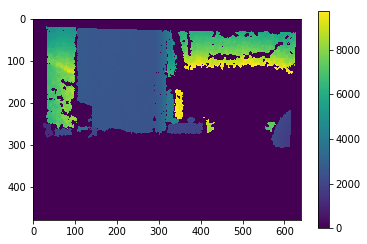

In [266]:
plt.imshow(get_depth())
plt.colorbar()

In [267]:
target_coords = [[1, 2, 3], [4, 5, 6], [0, 0, 1], [1, 0, 2]]

def get_coords(target_coords):
    results_camera = []
    results_robot  = []
    for target_xyz in target_coords:
        try:
            r_robot = move_robot(target_xyz) # tune params! 
            r_camera = find_ball()
            results_camera.append(r_camera)
            results_robot.append(r_robot)
        except Exception as e:
            print("{} failed!".format(target_xyz))
            print(e)
    return results_camera, results_robot

In [34]:
def optimize_transformation(xyzs_camera, xyzs_robot):
    def fn(xyz_camera, r0, r1, r2, t):
        x, y, z = xyz_camera
        return r0 * x + r1 * y + r2 * z + t
    r1tx, r1cov = curve_fit(fn, xyzs_camera, xyzs_robot[:, 0])
    r2ty, r2cov = curve_fit(fn, xyzs_camera, xyzs_robot[:, 1])
    r3tz, r3cov = curve_fit(fn, xyzs_camera, xyzs_robot[:, 2])
    T = np.array([r1tx, r2ty, r3tz, [0, 0, 0, 1]])
    return T  

In [ ]:
def find_xyzr(pc):
    def func(x, x0, y0, z0, r):
        return (x[0] - x0)**2 + (x[1] - y0)**2 + (x[2] - z0)**2 - r0**2
    n = len(pc)
    popt, pcov = curve_fit(func, pc, np.ones(n))
    return popt